In [5]:
# Authors: Jeroen BUil
# License: BSD-3-Clause

# Init

In [6]:
import os
import glob as glob 
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm

from IPython.display import clear_output

from deegtal_coding_task.config import *

import torch
import torch.nn as nn
import torch.nn.functional as F

# Load model

In [3]:
#TODO: Move this to a seperate .py file

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # 32x32 after pooling
        self.fc2 = nn.Linear(128, 2)  # 2 classes: Group1, Group2
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [49]:
# Load model
curr_dir = os.path.abspath("")
model_path = Path(curr_dir).parent.resolve() / "models" / "CNN_Model.pkl"

model = SimpleCNN()
model.load_state_dict(torch.load(model_path, weights_only=True))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set to eval mode
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

# XAI

In [47]:
import torch
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import normalize
from torchvision import datasets, transforms
from PIL import Image

In [41]:
glob.glob(str(INTERIM_DATA_DIR / f"Group{1}_Spectograms" / "*.png"))[0]

'C:\\Users\\buil003\\Documents\\Code\\deegtal_coding_task\\data\\interim\\Group1_Spectograms\\group1_recording1_window0.png'

In [44]:
[glob.glob(str(INTERIM_DATA_DIR / f"Group{iGroup+1}_Spectograms" / "*.png"))[0] for iGroup in range(2)]

['C:\\Users\\buil003\\Documents\\Code\\deegtal_coding_task\\data\\interim\\Group1_Spectograms\\group1_recording1_window0.png',
 'C:\\Users\\buil003\\Documents\\Code\\deegtal_coding_task\\data\\interim\\Group2_Spectograms\\group2_recording1_window0.png']

In [54]:
# Load a sample image from each class (replace with actual paths to images from Group1 and Group2)
sample_image_paths = [glob.glob(str(INTERIM_DATA_DIR / f"Group{iGroup+1}_Spectograms" / "*.png"))[0] for iGroup in range(2)]
sample_images = [Image.open(path).convert('RGB') for path in sample_image_paths]

# Apply the same transformations as used for training
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize images to a common size
    transforms.ToTensor(),           # Convert images to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,)),
])

# Transform the sample images
transformed_images = [transform(img).unsqueeze(0).to(device) for img in sample_images]

Generating heatmap for class 1


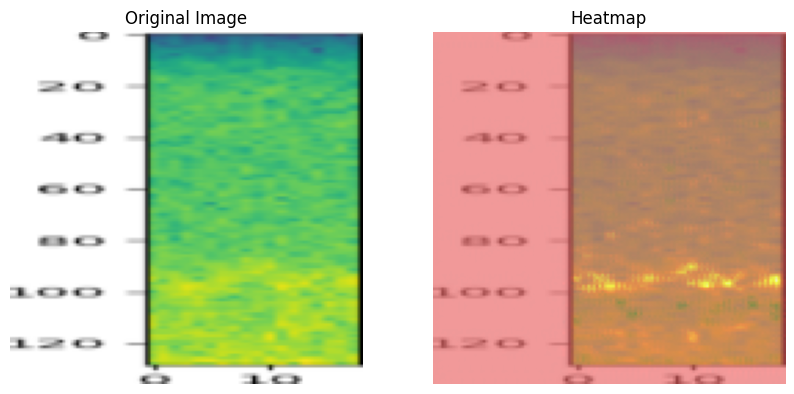

Generating heatmap for class 2


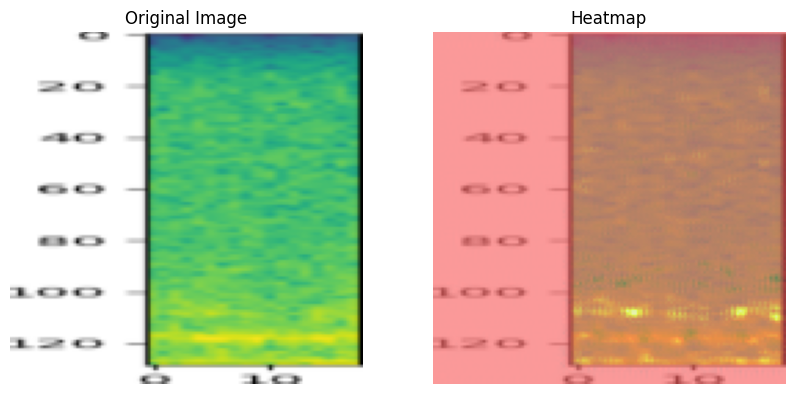

In [55]:
# Define Captum's IntegratedGradients for the model
ig = IntegratedGradients(model)

# Function to generate heatmap for a given image and class label
def generate_heatmap(model, input_image, target_class):
    # Compute attributions with IntegratedGradients
    attributions, _ = ig.attribute(input_image, target=target_class, return_convergence_delta=True)
    attributions = attributions.squeeze().cpu().detach().numpy()
    
    # Aggregate across color channels
    attributions = np.mean(attributions, axis=0)
    
    # Normalize attributions for visualization
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())
    
    # Plot the original image and heatmap
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original Image
    img = input_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    img = (img * 0.5) + 0.5  # Undo normalization for visualization
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    # Heatmap
    ax[1].imshow(img, alpha=0.6)
    ax[1].imshow(attributions, cmap='hot', alpha=0.4)
    ax[1].set_title("Heatmap")
    ax[1].axis("off")
    
    plt.show()

# Generate heatmaps for each sample image
for i, img in enumerate(transformed_images):
    print(f"Generating heatmap for class {i+1}")
    generate_heatmap(model, img, target_class=i)